In [1]:
### Install libraries ###

#'!pip install git+https://github.com/HumanCompatibleAI/overcooked_ai.git

In [2]:
### Imports ###

from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
import gym
import numpy as np
import torch
from PIL import Image
import os
from IPython.display import display, Image as IPImage
# from google.colab import drive

In [3]:
from torch.distributions import OneHotCategorical
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import gym
from collections import deque
import random
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer
from overcooked_ai_py.agents.agent import NNPolicy, AgentFromPolicy, AgentPair
from PIL import Image
import os
from IPython.display import display, Image as IPImage
from copy import deepcopy
from typing import List

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:


class Actor(nn.Module):
    def __init__(self, n_state, n_action, n_hidden=64, n_layer=3, dropout=False, p_dropout=0.2):
        """
        mapping state to q(state,action) to get q-values
        using 3 layer full connected nn
        n_state (int): Dimension of each state, 8 for lunarLander env, 6 continues, 2 discrete (0 or 1)
        n_action (int): Dimension of each action, 4 for lunarLander agent, 

        """
        super(Actor, self).__init__()
        layers = [n_state]+[n_hidden]*(n_layer-1)+[n_action]
        networklayers = []
        for i, n_current in enumerate(layers[:-1]):
            networklayers.append(nn.Linear(n_current, layers[i+1]))
            if dropout:
                networklayers.append(nn.Dropout(p=p_dropout))
            if i < n_layer - 1:
                networklayers.append(nn.ReLU())
        self.fc = nn.Sequential(*networklayers)
        # self.fc = nn.Sequential(nn.Linear(n_state, n_hidden),
        #                        nn.ReLU(),
        #                        nn.Linear(n_hidden, n_hidden),
        #                        nn.ReLU(),
        #                        nn.Linear(n_hidden, n_action))

    def forward(self, x):
        return self.fc(x)


class Critic_centralized(nn.Module):
    # Inspired by https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py
    def __init__(self, n_state=96, n_action=6, n_agents=2, n_hidden=64):
        """
        mapping state to q(state,action) to get q-values
        using 3 layer full connected nn
        n_state (int): Dimension of all state, 96 for overcooked-AI as obs[0] has the same information as obs[1], just the index is different
                       So, n_state here is the obs[0]. For other MADDPGs, n_state need to include all observed information for all agents.
        n_action (int): Dimension of all action, 12 for overcooked-AI(6x2)

        """
        super(Critic_centralized, self).__init__()
        # Here, because states are fully observed for all agents, thus, just using agent0's obs as the state information
        # Otherwise, the input of the first layer should be n_state*n_agents
        # Also, for discrete actions, we could simply add actions to the first layer
        # For continuous actions, actions could be added to the second layer after one linear transformation of the states.
        #self.ln1 = nn.Linear(n_state, 128)
        #self.ln2 = nn.Linear(128+n_action*n_agents, n_hidden)
        # self.ln3 = nn.Linear(64, 64)
        self.ln1 = nn.Linear(n_state+n_action*n_agents, 128)
        self.ln2 = nn.Linear(128, n_hidden)
        self.ln3 = nn.Linear(n_hidden, n_hidden)
        self.ln4 = nn.Linear(n_hidden, 1)

    def forward(self, obs0, actions):
        #x = F.relu(self.ln1(obs0))
        #x = torch.cat([x, actions], 1)  # dim0:sample, dim1:obs
        x = torch.cat([obs0, actions], 1)  # dim0:sample, dim1:obs
        #print(f"actions: {actions}")
        #print(f"actions shape: {actions.shape}")
        #print(f"obs:{obs0}")
        #print(f"obs shape:{obs0.shape}")
        x = F.relu(self.ln1(x))
        x = F.relu(self.ln3(F.relu(self.ln2(x))))
        return self.ln4(x)

In [7]:
class GST:
    """
        Gapped Straight-Through Estimator

        With help from: https://github.com/chijames/GST/blob/267ab3aa202d7a0cfd5b5861bd3dcad87faefd9f/model/basic.py
    """

    def __init__(self, temperature=0.7, gap=1.0):
        self.temperature = temperature
        self.gap = gap

    @torch.no_grad()
    def _calculate_movements(self, logits, DD):
        max_logit = logits.max(dim=-1, keepdim=True)[0]
        selected_logit = torch.gather(
            logits, dim=-1, index=DD.argmax(dim=-1, keepdim=True))
        m1 = (max_logit - selected_logit) * DD
        m2 = (logits + self.gap - max_logit).clamp(min=0.0) * (1 - DD)
        return m1, m2

    def __call__(self, logits, need_gradients=True):
        DD = OneHotCategorical(logits=logits).sample()
        if need_gradients:
            m1, m2 = self._calculate_movements(logits, DD)
            surrogate = F.softmax((logits + m1 - m2) /
                                  self.temperature, dim=-1)
            """Returns `value` but backpropagates gradients through `surrogate`."""
            return surrogate + (DD - surrogate).detach()
        else:
            return DD

In [8]:
from torch.distributions import Gumbel
from torch import Tensor
GUMBEL_DIST = Gumbel(loc=Tensor([0]), scale=Tensor([1]))


def replace_gradient(value, surrogate):
    """Returns `value` but backpropagates gradients through `surrogate`."""
    return surrogate + (value - surrogate).detach()

class STGS:
    """
        Straight-Through Gumbel Softmax estimator
    """

    def __init__(self, temperature=1.0):
        self.temperature = temperature

    def __call__(self, logits, need_gradients=None):
        gumbel_noise = GUMBEL_DIST.sample(
            logits.shape).squeeze(-1).to(device)  # ~ Gumbel (0,1)
        perturbed_logits = (logits + gumbel_noise) / \
            self.temperature  # ~ Gumbel(logits,tau)
        y_soft = F.softmax(perturbed_logits, dim=-1)
        y_hard = F.one_hot(y_soft.argmax(dim=-1), num_classes=logits.shape[-1])
        return replace_gradient(value=y_hard, surrogate=y_soft)

In [9]:
GUMBEL_DIST.sample(
    (3,2)).squeeze(-1).to(device)

tensor([[0.1291, 4.9359],
        [0.5417, 2.3871],
        [1.4574, 1.5073]], device='cuda:0')

In [10]:
temp = STGS(1)
temp(logits =torch.Tensor([1.2, 2.3,2.4]).to(device))

tensor([0., 0., 1.], device='cuda:0')

In [11]:
test = deque(maxlen=int(5))
test.append([1, 2, 3, [1,2], 2])
test.append([1, 2, 3, [1, 2], 3])
test.append([1, 2, 3, [1, 2], 4])
test.append([1, 2, 3, [1, 2], 50])
test2 = [2,3,5,60]
test

deque([[1, 2, 3, [1, 2], 2],
       [1, 2, 3, [1, 2], 3],
       [1, 2, 3, [1, 2], 4],
       [1, 2, 3, [1, 2], 50]],
      maxlen=5)

In [12]:
test2 = [e[4] for e in test]
p=np.array(test2)/sum(test2)

In [13]:
p

array([0.03389831, 0.05084746, 0.06779661, 0.84745763])

In [14]:
random.sample(test,2)

[[1, 2, 3, [1, 2], 3], [1, 2, 3, [1, 2], 2]]

In [15]:
class agent(object):
    def __init__(self, n_state, n_action,  n_hidden=64, lr_actor=1e-4, lr_critic=1e-3, gamma=0.99,
                 batch_size=64, replay_mem=10000, update_frequency=5, tau=1e-3, gradient_clip=1.0, ge_temp=0.7, policy_regulariser=0.001):
        self.n_state = n_state
        self.n_action = n_action
        self.n_hidden = n_hidden
        # learning settings
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        # deep networks

        self.actor = Actor(n_state, n_action).to(device)
        self.actor_target = deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(
            self.actor.parameters(), lr=self.lr_actor, eps=0.001)

        self.critic = Critic_centralized(n_state, n_action, 2).to(device)
        self.critic_target = deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), lr=self.lr_critic, eps=0.001)

        self.gradient_clip = gradient_clip

        self.critic_criterion = nn.MSELoss()  # Loss function

        self.tau = tau

        # Gradient estimator
        self.gradient_estimator = STGS(ge_temp)  # GST(temperature=ge_temp)
        self.policy_regulariser = policy_regulariser
    
    def choose_action(self, obs):
        policy_output = self.actor(Tensor(obs))
        gs_output = self.gradient_estimator(
            policy_output, need_gradients=False)
        return torch.argmax(gs_output, dim=-1)
    
    def targetAction(self,obs):
        # For critic
        policy_output = self.actor_target(Tensor(obs))
        gs_output = self.gradient_estimator(
            policy_output, need_gradients=False)
        return torch.argmax(gs_output, dim=-1)

    def update_critic(self, all_obs, all_nobs, target_actions_per_agent, sampled_actions_per_agent, rewards, dones, gamma):
        target_actions = torch.concat(target_actions_per_agent, axis=1)
        sampled_actions = torch.concat(sampled_actions_per_agent, axis=1)

        Q_next_target = self.critic(torch.concat(
            (all_nobs, target_actions), dim=1))
        target_ys = rewards + (1 - dones) * gamma * Q_next_target
        behaviour_ys = self.critic(torch.concat(
            (all_obs, sampled_actions), dim=1))

        loss = F.mse_loss(behaviour_ys, target_ys.detach())

        self.optim_critic.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.critic.parameters(), self.gradient_clip)
        self.optim_critic.step()

In [16]:

class MADDPG(object):  # Define ONE Agent
    def __init__(self, n_agents, n_state, n_action,  n_hidden=64, lr_actor=1e-4, lr_critic=1e-3, gamma=0.99,
                 batch_size=64, replay_mem=10000, update_frequency=5, tau=1e-3, gradient_clip=1.0, ge_temp=0.7, policy_regulariser=0.001):
        self.n_state = n_state
        self.n_action = n_action
        self.n_hidden = n_hidden
        self.n_agents = n_agents
        # learning settings
        self.lr_actor = lr_actor
        self.lr_critic = lr_critic
        self.gamma = gamma
        # deep networks
        
        self.actors = [Actor(n_state, n_action).to(device)
                       for i in range(n_agents)]
        self.actors_target = [Actor(n_state, n_action).to(device)
                              for i in range(n_agents)]
        self.actors_optimizer = [
            optim.Adam(a.parameters(), lr=self.lr_actor, eps=0.001) for a in self.actors]
        
        self.critics = [Critic_centralized(n_state, n_action, n_agents).to(device) for i in range(n_agents)]
        self.critics_target = [Critic_centralized(
            n_state, n_action, n_agents).to(device) for i in range(n_agents)]
        self.critic_optimizer = [
            optim.Adam(a.parameters(), lr=self.lr_critic, eps=0.001) for a in self.critics]
        

        self.gradient_clip = gradient_clip

        self.critic_criterion = nn.MSELoss()  # Loss function

        # Replay memory buffer
        self.buffer = deque(maxlen=int(replay_mem))
        self.t_step = 0
        self.batch_size = batch_size
        self.update_frequency = update_frequency
        self.tau = tau

        # Gradient estimator
        self.gradient_estimator = STGS(ge_temp)  # GST(temperature=ge_temp)
        self.policy_regulariser = policy_regulariser

        # To device
        # for a in self.actors:
        #    a.to(device)
        # for c in self.critics:
        #    c.to(device)

    def choose_agent_action(self, s, agentidx: int):
        """Choose next action based on actor logits"""
        state = torch.tensor(s).float().unsqueeze(0).to(device)

        policy_output = self.actors[agentidx](state)
        gs_output = self.gradient_estimator(
            policy_output, need_gradients=False)
        return torch.argmax(gs_output, dim=-1)

        # First get q(s,a) values
        state = torch.tensor(s).float().unsqueeze(0).to(device)

        self.q_local.eval()
        with torch.no_grad():
            action_values = self.q_local(state)
        self.q_local.train()

        if np.random.random() < epsilon:
            return np.random.randint(self.n_action)
        return torch.argmax(action_values).to('cpu').item()

    def acts(self, obs: List):
        actions = [self.choose_agent_action(
            obs[i], i) for i in range(self.n_agents)]
        return actions

    def act_target(self, s, agentidx: int):
        state = torch.tensor(s).float().unsqueeze(0).to(device)
        policy_output = self.actors_target[agentidx](state)
        gs_output = self.gradient_estimator(
            policy_output, need_gradients=False)
        return torch.argmax(gs_output, dim=-1)
    
    def step(self, state, action, reward, next_state, done,weight):
        # Add to buffer
        self.buffer.append([state, action, reward, next_state, done, weight])
        #print(
        #    f"current buffer append: {[state, action, reward, next_state, done]}")
        # update based on update_frequency
        self.t_step = (self.t_step + 1) % self.update_frequency
        if self.t_step == 0:
            # Only learn when there is enough samples in the buffer to make the update robust
            if len(self.buffer) > self.batch_size:
                w = np.array([e[5] for e in self.buffer])
                p = np.array(w)/sum(w)
                for iagent in range(self.n_agents):
                    experiences = [self.buffer[i] for i in np.random.choice(
                        range(len(self.buffer)), size=self.batch_size, replace=False, p=p)]
                    #experiences = random.sample(self.buffer, self.batch_size)
                    # experiences = self.buffer[np.random.choice(self.buffer.shape[0], self.batch_size, replace=False),:]
                    # print("exp shape:",np.array(experiences).shape)
                    self.update_networks(experiences, iagent)
    
    def update_critic(self, iagent,obs, obs_new, target_actions_one_hot, current_actions_one_hot, rewards, dones):
        #First concat obs and actions 
        target_actions = torch.concat(target_actions_one_hot, axis=1)
        current_actions = torch.concat(current_actions_one_hot, axis=1)
        #print(f"obs new dim: {obs_new}")
        #print(f"target_actions xxxxx: {target_actions}")
        #print(f"torch.concat {torch.concat([obs_new,target_actions],dim=1)}")
        q_next_target = self.critics_target[iagent](
            obs_new, target_actions)  # This is from DDPG
        #q_next_target = self.critic(obs_new, target_actions) # This is from MADDPG revisiting
        q_targets = rewards + self.gamma * q_next_target * (1 - dones)

        #print(f"obs old: {obs}")
        #print(f"current_actions xxxxx: {current_actions}")
        #print(f"torch.concat {torch.concat([obs,current_actions],dim=1)}")

        q_current = self.critics[iagent](obs, current_actions)

        loss = self.critic_criterion(q_current, q_targets.detach())

        self.critic_optimizer[iagent].zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critics[iagent].parameters(), self.gradient_clip)
        self.critic_optimizer[iagent].step()

    def update_actor(self, iagent, obs_actor, obs_critic, current_actions_one_hot):
        policy_outputs = self.actors[iagent](obs_actor)
        gs_outputs = self.gradient_estimator(policy_outputs)

        _sampled_actions = deepcopy(current_actions_one_hot)
        _sampled_actions[iagent] = gs_outputs
        target_actions = torch.concat(_sampled_actions, axis=1)
        
        loss = - self.critics[iagent](obs_critic, target_actions).mean()
        loss += (policy_outputs ** 2).mean() * self.policy_regulariser
        self.actors_optimizer[iagent].zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actors[iagent].parameters(), self.gradient_clip)
        self.actors_optimizer[iagent].step()

    def soft_update(self, target, source, t):
        for p_local, p_target in zip(source.parameters(), target.parameters()):
            # p_target = tau*p_local + (1 - tau)*p_target
            p_target.data.copy_(t*p_local.data + (1.0-t)*p_target.data)
    def update_networks(self, experiences,iagent):
        # extract states,actions, rewards, next_states,dones
        states = [torch.from_numpy(
            np.vstack([e[0][iagent] for e in experiences if e is not None])).float().to(device) for iagent in range(self.n_agents)]
        actions = [torch.from_numpy(
            np.vstack([e[1][iagent] for e in experiences if e is not None])).long().to(device) for iagent in range(self.n_agents)]
        rewards = torch.from_numpy(
            np.vstack([e[2] for e in experiences if e is not None])).float().to(device)
        next_states = [torch.from_numpy(
            np.vstack([e[3][iagent] for e in experiences if e is not None])).float().to(device) for iagent in range(self.n_agents)]
        dones = torch.from_numpy(
            np.vstack([e[4] for e in experiences if e is not None])).float().to(device)
        
        #print(f"actions: {actions}")
        #print(f"rewards:{rewards}")
        #print(f"states:{states}")
        # target_actions would 0-5 for each agent
        target_actions = [
            self.act_target(next_states[iagent],iagent).squeeze(0)
            for iagent in range(self.n_agents)
        ]
        #print(f"target_actions:{target_actions}")
        target_actions_one_hot = [
            F.one_hot(target_actions[iagent],
                      num_classes=self.n_action)
            for iagent in range(self.n_agents)
        ]  # agent target next batch actions

        current_actions_one_hot = [
            F.one_hot(actions[iagent].to(torch.int64).squeeze(1),
                      num_classes=self.n_action)
            for iagent in range(self.n_agents)
        ]  # agent batch actions
        #print(f"obs new dim: {next_states[0]}")
        #print(f"actions[iagent] dim: {actions[0].shape}")
        #print(f"current_actions_one_hotxxxx: {current_actions_one_hot[1].shape}")
        self.update_critic(iagent,states[iagent], next_states[iagent],
                           target_actions_one_hot, current_actions_one_hot, rewards, dones)
        
        self.update_actor(
            iagent, obs_actor=states[iagent], obs_critic=states[iagent], current_actions_one_hot=current_actions_one_hot)

        # soft update target network
        
        for iagent in range(self.n_agents):
            self.soft_update(self.critics_target[iagent], self.critics[iagent], t=self.tau)
            self.soft_update(self.actors_target[iagent], self.actors[iagent], t=self.tau)
    

    def reset_lr_actor(self, newlr):
        self.lr_actor = newlr
        for iagent in range(self.n_agents):
            for g in self.actor_optimizers[iagent].param_groups:
                g['lr'] = self.lr_actor

    def reset_lr_critic(self, newlr):
        self.lr_critic = newlr
        for g in self.critic_optimizer.param_groups:
            g['lr'] = self.lr_critic

    def reset_batchsize(self, newbatchsize):
        self.batch_size = int(newbatchsize)

    def reset_tau(self, tau_new):
        self.tau = tau_new

    def reset_update_frequency(self, newfrequency):
        self.update_frequency = newfrequency

In [17]:
### Environment setup ###

# Swap between the 5 layouts here:
# layout = "cramped_room"
# layout = "asymmetric_advantages"
# layout = "coordination_ring"
# layout = "forced_coordination"
layout = "counter_circuit_o_1order"

# Reward shaping is disabled by default.  This data structure may be used for
# reward shaping.  You can, of course, do your own reward shaping in lieu of, or
# in addition to, using this structure.
reward_shaping = {
    "PLACEMENT_IN_POT_REW": 3,
    "DISH_PICKUP_REWARD": 3,
    "SOUP_PICKUP_REWARD": 5,
    'DISH_DISP_DISTANCE_REW': 0, 
    'POT_DISTANCE_REW': 0, 
    'SOUP_DISTANCE_REW': 0
}



# Length of Episodes.  Do not modify for your submission!
# Modification will result in a grading penalty!
horizon = 400

# Build the environment.  Do not modify!
mdp = OvercookedGridworld.from_layout_name(
    layout, rew_shaping_params=reward_shaping)
base_env = OvercookedEnv.from_mdp(mdp, horizon=horizon, info_level=0)
env = gym.make("Overcooked-v0", base_env=base_env,
               featurize_fn=base_env.featurize_state_mdp)

Computing MotionPlanner to be saved in /home/yshang/miniconda3/envs/cs7643group/lib/python3.10/site-packages/overcooked_ai_py/data/planners/counter_circuit_o_1order_mp.pkl
It took 0.16200017929077148 seconds to create mp


In [18]:
def dump(a):
    print(f"Agent Orientation: {a[0:4]}")
    print(f"Agent holdings: {a[4:8]}")
    print(f"Agent distance to onion,tomato,dish,soup: {a[8:16]}")
    print(f"N ingrediants in closest soup (Onion, tomato): {a[16:18]}")
    print(f"Agent distance to ServingArea, counter: {a[18:22]}")
    print(f"Pot 1 Available: {a[22]}")
    print(f"Pot 1 Status: {a[23:27]}")
    print(f"N of Onion, tomato in Pot 1: {a[27:29]}")
    print(f"Time remaining in Pot 1: {a[29]}")
    print(f"Distance to the Pot 1: {a[30:32]}")
    print(f"Pot Available 2: {a[32]}")
    print(f"Pot Status 2: {a[33:37]}")
    print(f"N of Onion, tomato in Pot 2: {a[37:39]}")
    print(f"Time remaining in Pot 2: {a[39]}")
    print(f"Distance to the Pot 2: {a[40:42]}")
    print(f"Facing walls: {a[42:46]}")

In [19]:
env.agent_idx

1

In [20]:
def calculate_rewards(baseenv_state, step, obs, obs_new, actions, agentidx):
    if actions == (4, 4):
        return [-1, -1, 0]
    # Define the rewards/penalties for different actions

    # Onion pickup/drops
    ONION_PICKUP_REWARD = 2
    USEFUL_ONION_PICKUP = 1
    USEFUL_ONION_DROP = -1
    ONION_DROP_REWARD = 0 #-2
    
    # potting
    ONION_DROP_TO_POT = [3, 4, 5]  # First onion, second onion, and third onion
    OPTIMAL_POTTING_REWARD = 0
    VIABLE_ONION_POTTING_REWARD = 0  # viable_onion_potting
    CATASTROPHIC_POTTING_PENALTY = -16  # viable_onion_potting

    # Cooking
    SOUP_COOKING_REWARD = 6  # only for optimal_onion_potting

    # DISH
    DISH_PICKUP_REWARD = 3
    DISH_PICKUP_REWARD_SOUPREADY = 3
    USEFUL_DISH_PICKUP = 1
    USEFUL_DISH_DROP = -1
    DISH_DROP_REWARD = 0 #-3

    # Serving
    SOUP_DROP_PENALTY = -5
    SOUP_PICKUP_REWARD = 5
    SOUP_DELIVERY_REWARD = 20  # shared between both agents

    USELESS_ACTION_PENALTY = 0  # Stay
    WALKING2WALL = -1
    # Initialize rewards for each agent
    rewards = [0, 0, 0]
    # Analyze the movement, if moving to a wall, then -1 penalty
    for agent_id in range(2):
        agent_ori = obs['overcooked_state'].players[agent_id].to_dict()[
            'orientation']  # Not swapping
        agent_pos = obs['overcooked_state'].players[agent_id].to_dict()[
            'position']  # Not swapping
        if actions[agent_id] <= 3:
            # Walking to a wall
            if obs['both_agent_obs'][abs(agent_id-agentidx)][42+int(actions[agent_id])] == 1:
                rewards[agent_id] += WALKING2WALL
            if False:
                print(
                    f"agent {agent_id}  previous ori:{agent_ori}     previous pos:{agent_pos} previous action {actions}")
                dump(obs['both_agent_obs'][abs(agent_id-agentidx)])  # Swapping
                print(
                    f"agent{agent_id} facing status: {obs['both_agent_obs'][abs(agent_id-agentidx)][42+int(actions[agent_id])]}")
                print(f"Agent{agent_id} current state:")
                print(baseenv_state)
            # if agent_ori[actions[agent_id]] == 'X':
            #    rewards[agent_id] += USELESS_ACTION_PENALTY

    # Analyze the actions and assign rewards/penalties
    # cumulative_sparse_rewards_by_agent,cumulative_shaped_rewards_by_agent
    # reshaped_states = [key for (key,values) in state]

    # optimal_onion_potting
    state = baseenv_state.game_stats
    action_tags = [0, 0]
    for action in state:
        if action == 'cumulative_sparse_rewards_by_agent' or action == 'cumulative_shaped_rewards_by_agent':
            continue
        for agent_id in range(2):
            if state[action][agent_id]:
                # print(f"action: {action}")
                if state[action][agent_id][-1] == step:  # last steps
                    action_tags[agent_id] = 1
                    if action == 'onion_pickup':
                        #only onion pick up from onion position will have the reward!
                        if abs(obs['both_agent_obs'][abs(agent_id-agentidx)][8]) + abs(obs['both_agent_obs'][abs(agent_id-agentidx)][9])==1:
                            rewards[agent_id] += ONION_PICKUP_REWARD
                    elif action == 'useful_onion_pickup':
                        rewards[agent_id] += USEFUL_ONION_PICKUP
                    elif action == 'useful_onion_drop':
                        rewards[agent_id] += USEFUL_ONION_DROP
                    elif action == 'onion_drop':
                        rewards[agent_id] += ONION_DROP_REWARD
                        
                    elif action == 'potting_onion':
                        if False:
                            print(
                                f"----------Onion Potting at Step: {step}-----------")
                            print(state)
                        # If poting with 3 onions
                        # pot location
                        agent_ori = obs_new['overcooked_state'].players[abs(agent_id)].to_dict()[
                            'orientation']
                        agent_pos = obs_new['overcooked_state'].players[abs(agent_id)].to_dict()[
                            'position']
                        pot_location = (
                            agent_ori[0]+agent_pos[0], agent_ori[1]+agent_pos[1])

                        ingre = baseenv_state.state.objects[pot_location].ingredients
                        if False:
                            print(f"pot location:{pot_location}")
                            print(
                                f"ingredients: {ingre}, length: {len(ingre)}")
                            print(baseenv_state)
                        rewards[agent_id] += ONION_DROP_TO_POT[len(ingre)-1]
                    elif action == 'optimal_onion_potting':
                        if False:
                            print(
                                f"----------Optimal Onion Potting at Step: {step}-----------")
                            print(state)
                            # If poting with 3 onions
                            # pot location
                            agent_ori = obs_new['overcooked_state'].players[abs(agent_id)].to_dict()[
                                'orientation']
                            agent_pos = obs_new['overcooked_state'].players[abs(
                                agent_id)].to_dict()['position']
                            pot_location = (
                                agent_ori[0]+agent_pos[0], agent_ori[1]+agent_pos[1])
                            print(f"pot location:{pot_location}")
                            # assert (pot_location==(2,0))
                            ingre = baseenv_state.state.objects[pot_location].ingredients
                            print(f"ingredients: {ingre}")
                            if len(ingre) == 3:
                                rewards[agent_id] += SOUP_COOKING_REWARD
                            print(baseenv_state)
                        rewards[agent_id] += OPTIMAL_POTTING_REWARD
                    elif action == 'viable_onion_potting':
                        # print(
                        #    f"----------Viable Onion Potting at Step: {step}-----------")
                        # print(state)
                        # print(baseenv_state)
                        rewards[agent_id] += VIABLE_ONION_POTTING_REWARD
                    elif action == 'catastrophic_onion_potting':
                        print(
                            f"----------Catastrophic Onion Potting at Step: {step}-----------")
                        print(state)
                        print(baseenv_state)
                        rewards[agent_id] += CATASTROPHIC_POTTING_PENALTY
                    elif action == 'useless_onion_potting':
                        print(
                            f"----------Useless Onion Potting at Step: {step}-----------")
                        print(state)
                        print(baseenv_state)
                        rewards[agent_id] += USELESS_ACTION_PENALTY
                    elif action == 'dish_pickup':
                        if abs(obs['both_agent_obs'][abs(agent_id-agentidx)][12]) + abs(obs['both_agent_obs'][abs(agent_id-agentidx)][13])==1:
                            rewards[agent_id] += DISH_PICKUP_REWARD
                        # only dish pick up from dish position will have the reward!
                        if abs(obs['both_agent_obs'][abs(agent_id-agentidx)][26]) + abs(obs['both_agent_obs'][abs(agent_id-agentidx)][36]) >= 1:
                            #Dish pickup and soup ready
                            rewards[agent_id] += DISH_PICKUP_REWARD_SOUPREADY
                            #print("Dish pick-up!")
                            #print(baseenv_state)
                            
                        #rewards[agent_id] += DISH_PICKUP_REWARD
                    elif action == 'useful_dish_pickup':
                        rewards[agent_id] += USEFUL_DISH_PICKUP
                    elif action == 'useful_dish_drop':
                        rewards[agent_id] += USEFUL_DISH_DROP
                    elif action == 'dish_drop':
                        rewards[agent_id] += DISH_DROP_REWARD
                    elif action == 'soup_pickup':
                        # check soup ready: baseenv_state.state.objects[pot_location].is_ready
                        if False:
                            print(
                                f"----------Soup Pickup at Step: {step}-----------")
                            print(state)
                            print(baseenv_state)
                            # If poting with 3 onions
                            # pot location
                        agent_ori = obs_new['overcooked_state'].players[agent_id].to_dict()[
                            'orientation']
                        agent_pos = obs_new['overcooked_state'].players[agent_id].to_dict()[
                            'position']
                        if False:
                            print(f"soup location:{agent_pos}")

                            print(f"soup_ready: {soup_ready}")
                        soup_ready = obs_new['overcooked_state'].players[agent_id].held_object.is_ready
                        if soup_ready:
                            rewards[agent_id] += SOUP_PICKUP_REWARD
                    elif action == 'soup_delivery':
                        rewards[agent_id] += SOUP_DELIVERY_REWARD
                    elif action == 'soup_drop':
                        rewards[agent_id] += SOUP_DROP_PENALTY
    
    # check start cooking:
    for agent_id in range(2):
        # Pot0 start cooking
        if obs_new['both_agent_obs'][abs(agent_id-agentidx)][25] == 1 and obs['both_agent_obs'][abs(agent_id-agentidx)][25] == 0: #cooking status change
            disx = obs_new['both_agent_obs'][abs(agent_id-agentidx)][30]
            disy = obs_new['both_agent_obs'][abs(agent_id-agentidx)][31]
            if abs(disx) + abs(disy) == 1:
                # Distance is 1
                # Then, check orientation: [0,1]-1,[0,-1]->0; [1,0] ->2, [-1,0] ->3
                ori_index = 0
                if (disx,disy) == (0,1):
                    ori_index = 1
                elif (disx,disy) == (1,0):
                    ori_index = 2
                elif (disx,disy) == (-1,0):
                    ori_index = 3
                if actions[agent_id] == 5 and obs_new['both_agent_obs'][abs(agent_id-agentidx)][27] == 3 and obs['both_agent_obs'][abs(agent_id-agentidx)][ori_index]==1:
                    #print(f"Agent{agent_id} Soup cooking Pot0!")
                    #dump(obs_new['both_agent_obs'][abs(agent_id-agentidx)])
                    #print(baseenv_state)
                    rewards[agent_id] += SOUP_COOKING_REWARD
        # Pot1 cooking
        if obs_new['both_agent_obs'][abs(agent_id-agentidx)][35] == 1 and obs['both_agent_obs'][abs(agent_id-agentidx)][35] == 0:
            disx = obs_new['both_agent_obs'][abs(agent_id-agentidx)][30]
            disy = obs_new['both_agent_obs'][abs(agent_id-agentidx)][31]
            if abs(disx) + abs(disy) == 1:
                # Distance is 1
                # Then, check orientation: [0,1]-1,[0,-1]->0; [1,0] ->2, [-1,0] ->3
                ori_index = 0
                if (disx, disy) == (0, 1):
                    ori_index = 1
                elif (disx, disy) == (1, 0):
                    ori_index = 2
                elif (disx, disy) == (-1, 0):
                    ori_index = 3
                if actions[agent_id] == 5 and obs_new['both_agent_obs'][abs(agent_id-agentidx)][37] == 3 and obs['both_agent_obs'][abs(agent_id-agentidx)][ori_index] == 1:
                    #print(f"Agent{agent_id} Soup cooking Pot1!")
                    #dump(obs_new['both_agent_obs'][abs(agent_id-agentidx)])
                    #print(baseenv_state)
                    rewards[agent_id] += SOUP_COOKING_REWARD
    # check useless action
    for agent_id in range(2):
        # If agent choose to interact, but it does nothing, then panaty
        if action_tags[agent_id] == 0 and actions[agent_id] == 5:
            rewards[agent_id] += USELESS_ACTION_PENALTY
    return rewards

In [21]:
def calculate_rewards2(baseenv_state, step, obs, obs_new, actions, agentidx):
    if actions == (4,4):
        return [-1,-1,0]
    # Define the rewards/penalties for different actions

    ## Onion pickup/drops
    ONION_PICKUP_REWARD = 3
    USEFUL_ONION_PICKUP = 1
    USEFUL_ONION_DROP = -1
    ONION_DROP_REWARD = 0
    ONION_DROP_TO_POT = [2,3,4] # First onion, second onion, and third onion
    ## potting
    SOUP_COOKING_REWARD = 5  # only for optimal_onion_potting
    OPTIMAL_POTTING_REWARD = 0
    VIABLE_ONION_POTTING_REWARD = 0 # viable_onion_potting
    CATASTROPHIC_POTTING_PENALTY = -16  # viable_onion_potting

    ## DISH
    DISH_PICKUP_REWARD = 3
    USEFUL_DISH_PICKUP = 1
    USEFUL_DISH_DROP = -1
    DISH_DROP_REWARD = 0
    
    ## Serving
    SOUP_DROP_PENALTY = -5
    SOUP_PICKUP_REWARD = 5
    SOUP_DELIVERY_REWARD = 0  # shared between both agents

    USELESS_ACTION_PENALTY = -1 #Stay

    # Initialize rewards for each agent
    rewards = [0, 0, 0]
    # Analyze the movement
    for agent_id in range(2):
        agent_ori = obs['overcooked_state'].players[agent_id].to_dict()['orientation'] # Not swapping
        agent_pos = obs['overcooked_state'].players[agent_id].to_dict()['position'] # Not swapping
        if actions[agent_id]<=3:
            if obs['both_agent_obs'][abs(agent_id-agentidx)][42+int(actions[agent_id])] == 1: #Walking to a wall
                rewards[agent_id] += USELESS_ACTION_PENALTY
            if False:
                print(f"agent {agent_id}  previous ori:{agent_ori}     previous pos:{agent_pos} previous action {actions}")
                dump(obs['both_agent_obs'][abs(agent_id-agentidx)]) #Swapping
                print(
                    f"agent{agent_id} facing status: {obs['both_agent_obs'][abs(agent_id-agentidx)][42+int(actions[agent_id])]}")
                print(f"Agent{agent_id} current state:")
                print(baseenv_state)
            #if agent_ori[actions[agent_id]] == 'X':
            #    rewards[agent_id] += USELESS_ACTION_PENALTY

    # Analyze the actions and assign rewards/penalties
    # cumulative_sparse_rewards_by_agent,cumulative_shaped_rewards_by_agent
    #reshaped_states = [key for (key,values) in state]

    # optimal_onion_potting
    state = baseenv_state.game_stats
    action_tags = [0,0]
    for action in state:
        if action == 'cumulative_sparse_rewards_by_agent' or action == 'cumulative_shaped_rewards_by_agent':
            continue
        for agent_id in range(2):
            if state[action][agent_id]:
                #print(f"action: {action}")
                if state[action][agent_id][-1]==step: #last steps
                    action_tags[agent_id] =1
                    if action == 'onion_pickup':
                        rewards[agent_id] += ONION_PICKUP_REWARD
                    elif action == 'useful_onion_pickup':
                        rewards[agent_id] += USEFUL_ONION_PICKUP
                    elif action == 'useful_onion_drop':
                        rewards[agent_id] += USEFUL_ONION_DROP
                    elif action == 'onion_drop':
                        rewards[agent_id] += ONION_DROP_REWARD
                        # If dropping to pot, add additional rewards
                        N_onion_beforeAction = obs['both_agent_obs'][abs(agent_id-agentidx)][16]
                        if N_onion_beforeAction <=2:
                            rewards[agent_id] += ONION_DROP_TO_POT[int(
                                N_onion_beforeAction)]
    
                    elif action == 'potting_onion':
                        if False:
                            print(
                                f"----------Onion Potting at Step: {step}-----------")
                            print(state)
                        # If poting with 3 onions
                        # pot location
                        agent_ori = obs_new['overcooked_state'].players[abs(agent_id)].to_dict()[
                            'orientation']
                        agent_pos = obs_new['overcooked_state'].players[abs(agent_id)].to_dict()[
                            'position']
                        pot_location = (
                            agent_ori[0]+agent_pos[0], agent_ori[1]+agent_pos[1])
                        
                        
                        ingre = baseenv_state.state.objects[pot_location].ingredients
                        if True:
                            print(f"pot location:{pot_location}")
                            print(
                                f"ingredients: {ingre}, length: {len(ingre)}")
                            print(baseenv_state)
                        if len(ingre) == 3:
                            rewards[agent_id] += SOUP_COOKING_REWARD
                        
                    elif action == 'optimal_onion_potting':
                        if False:
                            print(f"----------Optimal Onion Potting at Step: {step}-----------")
                            print(state)
                            #If poting with 3 onions
                            ## pot location
                            agent_ori = obs_new['overcooked_state'].players[abs(agent_id)].to_dict()[
                                'orientation']
                            agent_pos = obs_new['overcooked_state'].players[abs(
                                agent_id)].to_dict()['position']
                            pot_location = (
                                agent_ori[0]+agent_pos[0], agent_ori[1]+agent_pos[1])
                            print(f"pot location:{pot_location}")
                            #assert (pot_location==(2,0))
                            ingre = baseenv_state.state.objects[pot_location].ingredients
                            print(f"ingredients: {ingre}")
                            if len(ingre)==3:
                                rewards[agent_id] += SOUP_COOKING_REWARD
                            print(baseenv_state)
                        rewards[agent_id] += OPTIMAL_POTTING_REWARD
                    elif action == 'viable_onion_potting':
                        #print(
                        #    f"----------Viable Onion Potting at Step: {step}-----------")
                        #print(state)
                        #print(baseenv_state)
                        rewards[agent_id] += VIABLE_ONION_POTTING_REWARD
                    elif action == 'catastrophic_onion_potting':
                        print(
                            f"----------Catastrophic Onion Potting at Step: {step}-----------")
                        print(state)
                        print(baseenv_state)
                        rewards[agent_id] += CATASTROPHIC_POTTING_PENALTY
                    elif action == 'useless_onion_potting':
                        print(
                            f"----------Useless Onion Potting at Step: {step}-----------")
                        print(state)
                        print(baseenv_state)
                        rewards[agent_id] += USELESS_ACTION_PENALTY
                    elif action == 'dish_pickup':
                        rewards[agent_id] += DISH_PICKUP_REWARD
                    elif action == 'useful_dish_pickup':
                        rewards[agent_id] += USEFUL_DISH_PICKUP
                    elif action == 'useful_dish_drop':
                        rewards[agent_id] += USEFUL_DISH_DROP
                    elif action == 'dish_drop':
                        rewards[agent_id] += DISH_DROP_REWARD
                    elif action == 'soup_pickup':
                        # check soup ready: baseenv_state.state.objects[pot_location].is_ready
                        if False:
                            print(
                                f"----------Soup Pickup at Step: {step}-----------")
                            print(state)
                            print(baseenv_state)
                            # If poting with 3 onions
                            # pot location
                        agent_ori = obs_new['overcooked_state'].players[agent_id].to_dict()[
                                'orientation']
                        agent_pos = obs_new['overcooked_state'].players[agent_id].to_dict()[
                                'position']
                        if False:
                            print(f"soup location:{agent_pos}")
                            
                            print(f"soup_ready: {soup_ready}")
                        soup_ready = obs_new['overcooked_state'].players[agent_id].held_object.is_ready
                        if soup_ready:
                            rewards[agent_id] += SOUP_PICKUP_REWARD
                    elif action == 'soup_delivery':
                        rewards[agent_id] += SOUP_DELIVERY_REWARD
                    elif action == 'soup_drop':
                        rewards[agent_id] += SOUP_DROP_PENALTY
    # check useless action
    for agent_id in range(2):
        #If agent choose to interact, but it does nothing, then panaty
        if action_tags[agent_id] == 0 and actions[agent_id] == 5:
            rewards[agent_id] += USELESS_ACTION_PENALTY
    return rewards

In [22]:
def save_checkpoint(agent, episode,avgScore, filename="checkpoint.pth"):
    state = {
        'episode':episode,
        'average_score': avgScore,
        'actors': [agent.actors[i].state_dict() for i in range(2)],
        'actors_target': [agent.actors_target[i].state_dict() for i in range(2)],
        # actors_optimizer
        'actors_optimizer': [agent.actors_optimizer[i].state_dict() for i in range(2)],
        'critic': [agent.critics[i].state_dict() for i in range(2)],
        'critic_target': [agent.critics_target[i].state_dict() for i in range(2)],
        'critic_optimizer': [agent.critic_optimizer[i].state_dict() for i in range(2)]
    }
    save_dir = "./"
    torch.save(state, save_dir+filename)

In [23]:
def load_checkpoint(agent,filename="checkpoint.pth"):
    checkpoint = torch.load(filename)
    #episode_start = checkpoint['episode']
    agent.critic.load_state_dict(checkpoint['critic'])
    agent.critic_target.load_state_dict(checkpoint['critic_target'])
    agent.critic_optimizer.load_state_dict(checkpoint['critic_optimizer'])
    for iagent in range(2):
        agent.actors[iagent].load_state_dict(checkpoint['actors'][iagent])
        agent.actors_target[iagent].load_state_dict(
            checkpoint['actors_target'][iagent])
        agent.actors_optimizer[iagent].load_state_dict(
            checkpoint['actors_optimizer'][iagent])
        agent.actors[iagent] = agent.actors[iagent].to(device)
        agent.actors_target[iagent] = agent.actors_target[iagent].to(device)
        optimizer_to(agent.actors_optimizer[iagent], device)
        
    # Move to device
    agent.critic = agent.critic.to(device)
    agent.critic_target = agent.critic_target.to(device)
    optimizer_to(agent.optimizer, device)
    return checkpoint['episode']

def optimizer_to( optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(
                            device)

In [24]:
N_statespace = env.observation_space.shape[0] #96
N_actions = env.action_space.n #6


In [25]:
N_actions

6

In [26]:
parameters_test = {"n_hidden": 64,#128
                   "lr": 1e-3,
                   "gamma": 0.99,
                   "batch_size": 128,
                   "replay_mem": 10000,
                   "update_frequency": 5,
                "tau": 1e-3}

In [27]:
parameters_test["lr"]

0.001

In [28]:
if False:
    agent0 = DQNLearningAgent(N_statespace, N_actions, n_hidden=parameters_test['n_hidden'],
                            lr=parameters_test["lr"], gamma=parameters_test['gamma'], batch_size=parameters_test["batch_size"],
                            replay_mem=parameters_test["replay_mem"], update_frequency=parameters_test["update_frequency"], tau=parameters_test["tau"])

    agent1 = DQNLearningAgent(N_statespace, N_actions, n_hidden=parameters_test['n_hidden'],
                            lr=parameters_test["lr"], gamma=parameters_test['gamma'], batch_size=parameters_test["batch_size"],
                            replay_mem=parameters_test["replay_mem"], update_frequency=parameters_test["update_frequency"], tau=parameters_test["tau"])



In [29]:
def exe_agent(actorNet,s):
    """Choose next action based on actor logits"""
    state = torch.tensor(s).float().unsqueeze(0).to(device)
    actorNet.eval()
    logits = actorNet(state)
    #OneHotCategorical(logits).sample()
    actorNet.train()
    return torch.argmax(logits).to('cpu').item()


def exe_agent2(actorNet, s):
    state = torch.tensor(s).float().unsqueeze(0).to(device)
    actorNet.eval()
    logits = actorNet(state)
    actorNet.train()
    #OneHotCategorical(logits=logits).sample()
    action_onehot = OneHotCategorical(logits=logits).sample()
    return torch.argmax(action_onehot, dim=-1).to('cpu').item()

In [30]:
# agents_maddpg = MADDPG(n_agents=2, n_state=N_statespace, n_action=N_actions,  n_hidden=64, lr_actor=1e-3, lr_critic=1e-3, gamma=0.99,
#                       batch_size=64, replay_mem=10000, update_frequency=5, tau=1e-3, gradient_clip=1.0, ge_temp=0.7, policy_regulariser=0.001)
save_name_tag = layout

In [31]:
episode_start=0

In [32]:
episode_start

0

In [33]:
## Training
min_episode = 50
targetScore = 7
targetN = 5
num_episodes = 10000
verbose = False
# swap = True
best_avg_last = 0

N_converge = 0
N_converge_threshold = 5
breaktag = 1
converge = False
e = 0
scores_last = deque(maxlen=int(targetN))
scores = []

In [34]:
epsilon = 0.9
eps_decay = 0.99
epsilon_min = 0.05
epsilon_max = 0.6
n_epsmin = 0
N_reset_eps = 20

In [35]:
agents_maddpg = MADDPG(n_agents=2, n_state=N_statespace, n_action=N_actions,  n_hidden=128, lr_actor=1e-3, lr_critic=1e-3, gamma=0.99,
                       batch_size=64, replay_mem=10000, update_frequency=5, tau=1e-2, gradient_clip=1.0, ge_temp=0.7, policy_regulariser=0.01)

In [36]:
agents_maddpg.reset_batchsize(64)

In [37]:
verbose = False
epsilon = 0.9
num_episodes=1000

In [38]:
N_saveCircle = 2000
warmup_episodes = 30
steprewards_steps = 20
steprewards = 0  # steps with less than 0 rewards, maybe means local minimum
epsilon_episode_max = 0.9

In [39]:
# Test and debug
verbose = True
num_episodes = 2
start = warmup_episodes
episode_start = 1

In [40]:
episode_start = e
verbose = False
start = warmup_episodes

In [41]:
# Continue Training
num_episodes = 10000
verbose = False
start = warmup_episodes
episode_start = 0

In [42]:
#Training
num_episodes=10000
verbose = False
start = 1
episode_start = 0

In [ ]:
#More robust
episode_start = e
verbose = False
start = warmup_episodes
num_episodes = 10000
N_converge_threshold = 20

In [153]:
e

0

In [154]:
save_name_tag

'forced_coordination'

In [55]:
episode_start = e
verbose = True
start = warmup_episodes
num_episodes=2

In [155]:
epsilon

0.9

In [43]:
for e in range(start, num_episodes+warmup_episodes+1):
    if breaktag == 0:
        break
    # Episode termination flag
    done = False

    # The number of soups the agent pair made during the episode
    num_soups_made = 0

    # Reset the environment at the start of each episode
    obs = env.reset()
    #while env.agent_idx == 1:
    #    obs = env.reset()

    steps = 0
    warmup_tag = (e < warmup_episodes)
    steprewards = 0 #steps with less than 0 rewards
    epsilon_episode = 0
    while (not done) and breaktag == 1:
        # Obtain observations for each agent
        # obs0 = obs["both_agent_obs"][0]
        # obs1 = obs["both_agent_obs"][1]

        if env.agent_idx == 0:
            obs0 = obs["both_agent_obs"][0]
            obs1 = obs["both_agent_obs"][1]
        else:
            obs0 = obs["both_agent_obs"][1]
            obs1 = obs["both_agent_obs"][0]
        #if steprewards >= steprewards_steps and epsilon_episode <0.05:
        #    #reset epsilon
        #    epsilon_episode = epsilon_episode_max
        #    steprewards=0
        if warmup_tag or (np.random.random() < epsilon) :
            a0= np.random.randint(6)
            a1 = np.random.randint(6)
        else:
            a0 = exe_agent2(agents_maddpg.actors[0], obs0)
            a1 = exe_agent2(agents_maddpg.actors[1], obs1)
        if env.agent_idx == 0:
            action_merge = [a0, a1]
        else:
            action_merge = [a1, a0]
        # action_merge = [a0, a1]
        # print(f"action merge: {action_merge}")
        
        if False:
            steprewards = 0
            if a0<=3:
                if obs0[a0+41] == 1:
                    steprewards += -1
            if a1 <= 3:
                if obs1[a1+41] ==1:
                    steprewards += -1
        obs_new, R, done, info = env.step(action_merge)
        # if env.agent_idx ==0:
        #    obs, R, done, info = env.step([a0, a1])
        # else:
        #    obs, R, done, info = env.step([a1, a0])
        rewards = calculate_rewards(base_env, steps, obs,obs_new, (a0, a1), agentidx=env.agent_idx)
        # reshapedR = calculate_rewards(obs['overcooked_state'])
        # print(f"info {info}")
        # Obtain observations for each agent
        if env.agent_idx == 0:
            obs0_new = obs_new["both_agent_obs"][0]
            obs1_new = obs_new["both_agent_obs"][1]
        else:
            obs0_new = obs_new["both_agent_obs"][1]
            obs1_new = obs_new["both_agent_obs"][0]

        step_reward_combined = rewards[0]+rewards[1]+R
        if step_reward_combined <= 0:
            steprewards += 1
            #print(
            #    f"-----eps: {epsilon} \tstep:{steps} \tactions:{[a0, a1]} rewards: {rewards[0]+R},{rewards[1]+R}------")
            #print(base_env)
            pass
        elif step_reward_combined>=3:
            #print(
            #    f"-----eps: {epsilon} \tstep:{steps} \tactions:{[a0, a1]} rewards: {rewards[0]+R},{rewards[1]+R}------")
            #print(base_env)
            steprewards = 0
        if verbose:# or e>120:
            print(
                f"-----eps: {epsilon} \tstep:{steps} \t rewards: {rewards[0]+R},{rewards[1]+R}------")
            print(f"env.agent_idx:{env.agent_idx}")
            print(f"action: {(a0,a1)}")
            print(
                f"agent0 previous status:")
            dump(obs0)
            print(
                f"agent0 status:{obs_new['overcooked_state'].players[0].to_dict()}")
            print(
                f"agent1 status:{obs_new['overcooked_state'].players[1].to_dict()}")
            print(f"agent0 new status:")
            dump(obs0_new)
            #print(base_env.game_stats)
            print(base_env)

            
            # breaktag = 0
            # break
        weight=1
        #if potting, weight = 5
        #if cooking, weight = 10
        #if ready and has dish, weight = 10
        #if soup_pickup, weight = 10
        #if serve, weight = 10
        if obs0_new[27]-obs0[27] >= 1 or obs0_new[37]-obs0[37] >= 1:
            weight += 5
        if obs0_new[25]-obs0[25] >= 1 or obs0_new[35]-obs0[35] >= 1:
            weight += 15
        if (obs0[26]== 1 or obs0[36] == 1) and (obs0_new[6] ==1 or obs1_new[6] ==1):#Dish
            weight += 10
        if (obs0[26]==1 and obs0_new[5]-obs0[5] >= 1) or (obs1[26]==1 and obs1_new[5]-obs1[5] >= 1):#Soup pickup
            weight += 15
        if R >= 20:  # Soup serve
            weight += 15
        agents_maddpg.step(state=(obs0, obs1), action=(a0, a1), reward=step_reward_combined,  # info["shaped_r_by_agent"][0]+R,reshapedR[0]+R,
                           next_state=(obs0_new,obs1_new), done=done,weight=weight)

        # if info['shaped_r_by_agent'][0]+R !=0:
        #    print(f"current reward for agent0: {info['shaped_r_by_agent'][0]+R}")
        # Accumulate the number of soups made
        num_soups_made += int(R / 20)  # Each served soup generates 20 reward
        steps = steps + 1
        #epsilon_episode = epsilon_episode*eps_decay
        obs = obs_new
        # if steps % 10 == 0:
        # print(f"states:{obs['both_agent_obs'][0].shape}")
    # Display status
    scores.append(num_soups_made)
    scores_last.append(num_soups_made)
    meanscore_last = np.mean(scores_last)
    print("Ep {0}".format(e), end=" ")
    print("agent_idx {0}".format(env.agent_idx), end=" ")
    print(f"episilon {epsilon:.2f}", end=" ")
    print("number of soups made: {0}".format(num_soups_made))
    
    if epsilon > epsilon_min:
        # update epsilon greedy after each episode
        epsilon = epsilon * eps_decay
    else:
        # update n_epsmin
        n_epsmin = n_epsmin+1
        if num_soups_made < targetScore and n_epsmin % N_reset_eps == 0:  # If converged once, then not reset
            print(f'Episode {e}\tReset epsilon:{epsilon_max}')
            # save_checkpoint(avgScore=meanscore_last,filename=f"Score{meanscore_last:.2f}_checkpoint.pth.tar")
            # reset epsilon, and reduce learning rate
            epsilon = epsilon_max


    # Converge if scores does not change
    if e > min_episode and meanscore_last >= targetScore:
        converge = True
        N_converge = N_converge + 1
        # print(f'Episode {i}\tAverage Score: {meanscore_last:.2f}')
        if meanscore_last > best_avg_last:
            best_avg_last = meanscore_last
            save_checkpoint(agent=agents_maddpg, episode=e+episode_start, avgScore=meanscore_last,
                            filename=f'bestcheckpoint_episode{e+episode_start}_{save_name_tag}_maddpg_last.pth.tar')

    if converge and meanscore_last < targetScore:
        converge = False
        N_converge = 0
    # Save most recent checkpoint
    
    if e % N_saveCircle == 0:
        save_checkpoint(agent=agents_maddpg, episode=e+episode_start, avgScore=meanscore_last,
                        filename=f'checkpoint_episode{e+episode_start}_{save_name_tag}_maddpg_last.pth.tar')
        epi_df = [episode_start+x for x in range(e-N_saveCircle+1, e+1)]
        score_df = scores[(e-N_saveCircle):e]
        if len(score_df) < len(epi_df):
            score_df = [0 for i in range(len(epi_df)-len(score_df))]+score_df
        df = pd.DataFrame(
            data={"episode": epi_df, "Score": score_df})
        df.to_csv(f'score_history_{save_name_tag}_maddpg.csv',
                  mode='a', index=False, header=False)

    if N_converge >= N_converge_threshold:
        break

# The info flag returned by the environemnt contains special status info
# specifically when done == True.  This information may be useful in
# developing, debugging, and analyzing your results.  It may also be a good
# way for you to find a metric that you can use in evaluating collaboration
# between your agents.

# Save most recent checkpoint
save_checkpoint(agent=agents_maddpg, episode=e+episode_start,avgScore=meanscore_last,
                        filename=f'checkpoint_episode{e+episode_start}_{save_name_tag}_maddpg_last.pth.tar')
if e % N_saveCircle != 0:
    # such as i= 667, then save scores[0:667]
    # or i=1232, then save scores[1000:1232]
    j = e-e % N_saveCircle
    epi_df = [episode_start+x for x in range(j+1, e+1)]
    score_df = scores[j:e]
    if len(score_df) < len(epi_df):
        score_df = [0 for i in range(len(epi_df)-len(score_df))]+score_df
    df = pd.DataFrame(
        data={"episode": epi_df, "Score": score_df})

    df.to_csv(f'score_history_{save_name_tag}.csv',
                mode='a', index=False, header=False)
            
print("\nExample info dump:\n\n", info)

/home/yshang/miniconda3/envs/cs7643group/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/yshang/miniconda3/envs/cs7643group/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/yshang/miniconda3/envs/cs7643group/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/home/yshang/miniconda3/envs/cs7643group/lib/python3.10/site-packa

Ep 1 agent_idx 0 episilon 0.90 number of soups made: 0
Ep 2 agent_idx 0 episilon 0.89 number of soups made: 0
Ep 3 agent_idx 1 episilon 0.88 number of soups made: 0
Ep 4 agent_idx 1 episilon 0.87 number of soups made: 0
Ep 5 agent_idx 1 episilon 0.86 number of soups made: 0
Ep 6 agent_idx 0 episilon 0.86 number of soups made: 0
Ep 7 agent_idx 0 episilon 0.85 number of soups made: 0
Ep 8 agent_idx 0 episilon 0.84 number of soups made: 0
Ep 9 agent_idx 0 episilon 0.83 number of soups made: 0
Ep 10 agent_idx 0 episilon 0.82 number of soups made: 0
Ep 11 agent_idx 0 episilon 0.81 number of soups made: 0
Ep 12 agent_idx 1 episilon 0.81 number of soups made: 0
Ep 13 agent_idx 0 episilon 0.80 number of soups made: 0
Ep 14 agent_idx 0 episilon 0.79 number of soups made: 0
Ep 15 agent_idx 0 episilon 0.78 number of soups made: 0
Ep 16 agent_idx 1 episilon 0.77 number of soups made: 0
Ep 17 agent_idx 0 episilon 0.77 number of soups made: 0
Ep 18 agent_idx 1 episilon 0.76 number of soups made: 0
E

In [321]:
save_checkpoint(agent=agents_maddpg, episode=e+episode_start, avgScore=meanscore_last,
                filename=f'bestcheckpoint_episode{e+episode_start}_{save_name_tag}_maddpg_last.pth.tar')

In [296]:
epi_df = [episode_start+x for x in range(e-N_saveCircle+1, e+1)]
score_df = scores[(e-N_saveCircle):e]
if len(score_df) < len(epi_df):
    score_df = [0 for i in range(len(epi_df)-len(score_df))]+score_df
df = pd.DataFrame(
    data={"episode": epi_df, "Score": score_df})
df.to_csv(f'score_history_{save_name_tag}_maddpg.csv',
            mode='a', index=False, header=False)

In [ ]:
if e % N_saveCircle != 0:
    # such as i= 667, then save scores[0:667]
    # or i=1232, then save scores[1000:1232]
    j = e-e % N_saveCircle
    epi_df = [episode_start+x for x in range(j+1, e+1)]
    score_df = scores[j:e]
    if len(score_df) < len(epi_df):
        score_df = [0 for i in range(len(epi_df)-len(score_df))]+score_df
    df = pd.DataFrame(
        data={"episode": epi_df, "Score": score_df})

    df.to_csv(f'score_history_{save_name_tag}.csv',
              mode='a', index=False, header=False)

In [289]:
len(scores[(e-N_saveCircle):e])

471

In [295]:
len(scores)

471

In [251]:
pd.DataFrame(data={"episode": [
    episode_start+x for x in range(e-N_saveCircle+1, e+1)], "Score": scores[(e-N_saveCircle):e]})

ValueError: All arrays must be of the same length

In [58]:
agents_maddpg.actors[0].parameters

<bound method Module.parameters of Actor(
  (fc): Sequential(
    (0): Linear(in_features=96, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)>

In [57]:
agents_maddpg.critic

Critic_centralized(
  (ln1): Linear(in_features=108, out_features=128, bias=True)
  (ln2): Linear(in_features=128, out_features=64, bias=True)
  (ln3): Linear(in_features=64, out_features=1, bias=True)
)

In [37]:
#bestcheckpoint_episode600_asymmetric_advantages_agent1_last.pth.tar
#load_checkpoint(agent0, filename="bestcheckpoint_episode600_asymmetric_advantages_agent0_last.pth.tar")
#load_checkpoint(
#    agent1, filename="bestcheckpoint_episode600_asymmetric_advantages_agent1_last.pth.tar")

In [38]:
episode_start = 600
e

1

In [39]:
agent1.reset_lr(newlr=1e-3)  # 1e-3
agent0.reset_lr(newlr=1e-3)

In [40]:
epsilon = 0.05
eps_decay = 0.995
epsilon_min = 0.05
epsilon_max = 0.6
fine_tune_lr = False
lr_min = 1e-4
lr_max = 1e-2
min_episode = 50
targetScore = 7
targetN = 5

In [60]:
obs0

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0., -2.,
        3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0., -3.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
        0., -3.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0., -1., -2.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,
       -2.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3., -1.,  0.,  1.,  0.,
        1., -6.,  2.,  7.,  1.])

In [80]:
print(base_env)

X       X       P       X       X       

O       ↑1      ↑0{ø✓           O       

X                               X       

X       D       X       S       X       




In [57]:
base_env.state.objects[(2, 0)].value

20

In [62]:
base_env.state.objects[(2, 0)].ingredients

['onion']

In [314]:
base_env.game_stats

{'tomato_pickup': [[], []],
 'useful_tomato_pickup': [[], []],
 'tomato_drop': [[], []],
 'useful_tomato_drop': [[], []],
 'potting_tomato': [[], []],
 'onion_pickup': [[92, 221, 296], [24, 62, 253]],
 'useful_onion_pickup': [[92, 221, 296], [24, 62, 253]],
 'onion_drop': [[286], [38]],
 'useful_onion_drop': [[], []],
 'potting_onion': [[100, 307], [118, 277]],
 'dish_pickup': [[40, 51, 68, 87, 104], [129, 131, 175, 194, 283]],
 'useful_dish_pickup': [[], []],
 'dish_drop': [[50, 66, 69, 89, 210], [130, 149, 188, 237]],
 'useful_dish_drop': [[50, 210], [130, 149, 188]],
 'soup_pickup': [[], [302]],
 'soup_delivery': [[], [315]],
 'soup_drop': [[], []],
 'optimal_onion_potting': [[100, 307], [118, 277]],
 'optimal_tomato_potting': [[], []],
 'viable_onion_potting': [[100, 307], [118, 277]],
 'viable_tomato_potting': [[], []],
 'catastrophic_onion_potting': [[], []],
 'catastrophic_tomato_potting': [[], []],
 'useless_onion_potting': [[], []],
 'useless_tomato_potting': [[], []],
 'cumul

In [26]:
base_env

X       X       X       X       X       X       X       X       X       

O       ↑1o     Xo      S       X       O       Xd              S       

X                               P       ↑0o                     X       

X                               P                               X       

X       X       X       D       X       D       X       X       X       


In [22]:
ag1 = obs['both_agent_obs'][0]
ag2 = obs['both_agent_obs'][1]
ag1[0:46]-ag2[46:92]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
obs['overcooked_state'].all_objects_by_type

defaultdict(list,
            {'dish': [dish@(6, 1)],
             'onion': [onion@(2, 1), onion@(5, 2), onion@(1, 1)]})

In [24]:
dump(ag1)

Agent Orientation: [1. 0. 0. 0.]
Agent holdings: [1. 0. 0. 0.]
Agent distance to onion,tomato,dish,soup: [0. 0. 0. 0. 2. 3. 0. 0.]
N ingrediants in closest soup (Onion, tomato): [0. 0.]
Agent distance to ServingArea, counter: [2. 0. 0. 0.]
Pot 1 Available: 1.0
Pot 1 Status: [1. 0. 0. 0.]
N of Onion, tomato in Pot 1: [0. 0.]
Time remaining in Pot 1: 0.0
Distance to the Pot 1: [3. 1.]
Pot Available 2: 1.0
Pot Status 2: [1. 0. 0. 0.]
N of Onion, tomato in Pot 2: [0. 0.]
Time remaining in Pot 2: 0.0
Distance to the Pot 2: [3. 2.]
Facing walls: [1. 0. 1. 1.]


In [25]:
dump(ag2)

Agent Orientation: [1. 0. 0. 0.]
Agent holdings: [1. 0. 0. 0.]
Agent distance to onion,tomato,dish,soup: [0. 0. 0. 0. 0. 2. 0. 0.]
N ingrediants in closest soup (Onion, tomato): [0. 0.]
Agent distance to ServingArea, counter: [ 3. -1.  0.  0.]
Pot 1 Available: 1.0
Pot 1 Status: [1. 0. 0. 0.]
N of Onion, tomato in Pot 1: [0. 0.]
Time remaining in Pot 1: 0.0
Distance to the Pot 1: [-1.  0.]
Pot Available 2: 1.0
Pot Status 2: [1. 0. 0. 0.]
N of Onion, tomato in Pot 2: [0. 0.]
Time remaining in Pot 2: 0.0
Distance to the Pot 2: [-1.  1.]
Facing walls: [1. 0. 0. 1.]


In [319]:
obs['overcooked_state'].to_dict()

{'players': [{'position': (1, 2), 'orientation': (-1, 0), 'held_object': None},
  {'position': (3, 2), 'orientation': (0, 1), 'held_object': None}],
 'objects': [{'name': 'onion', 'position': (4, 2)},
  {'name': 'dish', 'position': (1, 0)},
  {'name': 'dish', 'position': (2, 3)},
  {'name': 'dish', 'position': (0, 2)},
  {'name': 'onion', 'position': (3, 0)},
  {'name': 'soup',
   'position': (2, 0),
   '_ingredients': [{'name': 'onion', 'position': (2, 0)}],
   'cooking_tick': -1,
   'is_cooking': False,
   'is_ready': False,
   'is_idle': True,
   'cook_time': -1,
   '_cooking_tick': -1}],
 'bonus_orders': [],
 'all_orders': [{'ingredients': ('onion', 'onion', 'onion')}],
 'timestep': 316}

In [57]:
obs['overcooked_state'].players

((1, 2) facing (0, -1) holding None, (3, 1) facing (0, -1) holding None)

In [321]:
if obs['overcooked_state'].players[1].held_object:
    if obs['overcooked_state'].players[1].held_object.name == 'soup':
        obs['overcooked_state'].players[1].held_object.ingredients

# state of the mdp
mdp_state = obs['overcooked_state']
mdp_state

In [54]:
obs['overcooked_state'].players[0]

(1, 2) facing (0, -1) holding None

In [40]:
#mdp_state.get_all_pots()

AttributeError: 'OvercookedState' object has no attribute 'get_all_pots'

In [107]:
dir(base_env)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_episode_info',
 '_get_discounted_rewards_with_horizon',
 '_mlam',
 '_mp',
 '_prepare_info_dict',
 '_update_game_stats',
 'copy',
 'display_states',
 'env_params',
 'execute_plan',
 'featurize_state_mdp',
 'from_mdp',
 'game_stats',
 'get_agent_infos_for_trajectories',
 'get_discounted_rewards',
 'get_rollouts',
 'horizon',
 'info_level',
 'is_done',
 'lossless_state_encoding_mdp',
 'mdp',
 'mdp_generator_fn',
 'mlam',
 'mlam_params',
 'mp',
 'num_mdp',
 'potential',
 'print_state_transition',
 'proportion_stuck_time',
 'reset',
 'run_agents',
 'start_state_fn',
 'state',
 'step',
 'variable_mdp']

In [110]:
### Evaluate your agent ###

# This is where you would rollout episodes with your trained agent.
# The below code is a partcular way to rollout episodes in a format
# compatible with a state visualizer, if you'd like to visualize what your
# agents are doing during episodes.  Visualization is in the next cell.

class StudentPolicy(NNPolicy):
    """ Generate policy """
    def __init__(self):
        super(StudentPolicy, self).__init__()

    def state_policy(self, state, agent_index):
        """
        This method should be used to generate the poiicy vector corresponding to
        the state and agent_index provided as input.  If you're using a neural
        network-based solution, the specifics depend on the algorithm you are using.
        Below are two commented examples, the first for a policy gradient algorithm
        and the second for a value-based algorithm.  In policy gradient algorithms,
        the neural networks output a policy directly.  In value-based algorithms,
        the policy must be derived from the Q value outputs of the networks.  The
        uncommented code below is a placeholder that generates a random policy.
        """
        #print(f"state:")
        #print(state)
        featurized_state = base_env.featurize_state_mdp(state)
        input_state = torch.FloatTensor(
            featurized_state[abs(agent_index)]).unsqueeze(0).to(device)
        
        # -env.agent_idx
        
        #print(f"input_state for idx{env.agent_idx} and agent:{agent_index}")
        #print(f"input_state:{input_state.cpu()}")
        #dump(input_state[0].cpu())
        #print(f"featurized_state: {featurized_state}")
        #print(base_env)
        # Example for policy NNs named "PNN0" and "PNN1"
        #with torch.no_grad():
        #   if agent_index == 0:
        #       action_probs = agents_maddpg.actors[0](input_state)[0].cpu().numpy()
        #   else:
        #       action_probs = agents_maddpg.actors[1](input_state)[0].cpu().numpy()

        # Example for Q value NNs named "QNN0" and "QNN1"
        action_probs = np.zeros(env.action_space.n)
        with torch.no_grad():
            if agent_index == 0:
                #action_probs[np.argmax(agents_maddpg.actors[0](input_state)[0].cpu().numpy())] = 1
                #print(
                #    f"exe_agent2 {exe_agent2(agents_maddpg.actors[0], s=input_state[0])}")
                action_probs[np.array(exe_agent2(
                    agents_maddpg.actors[abs(0-env.agent_idx)], s=input_state[0]))]=1
                
            else:
                action_probs[np.argmax(
                    agents_maddpg.actors[abs(1-env.agent_idx)](input_state)[0].cpu().numpy())] = 1

        # Random deterministic policy
        #action_probs = np.zeros(env.action_space.n)
        #action_probs[env.action_space.sample()] = 1

        return action_probs

    def multi_state_policy(self, states, agent_indices):
        """ Generate a policy for a list of states and agent indices """
        return [self.state_policy(state, agent_index) for state, agent_index in zip(states, agent_indices)]


class StudentAgent(AgentFromPolicy):
    """Create an agent using the policy created by the class above"""
    def __init__(self, policy):
        super(StudentAgent, self).__init__(policy)


# Instantiate the policies for both agents
policy0 = StudentPolicy()
policy1 = StudentPolicy()

# Instantiate both agents
agent0 = StudentAgent(policy0)
agent1 = StudentAgent(policy1)
agent_pair = AgentPair(agent0, agent1)

# Generate an episode
ae = AgentEvaluator.from_layout_name({"layout_name": layout}, {"horizon": horizon})
trajs = ae.evaluate_agent_pair(agent_pair, num_games=1)
print("\nlen(trajs):", len(trajs))

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_25713/2727114738.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(s).float().unsqueeze(0).to(device)
Avg rew: 200.00 (std: 0.00, se: 0.00); avg len: 400.00; : 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


len(trajs): 10


In [53]:
### Agent Visualization ###

##############################################################################
# The function StateVisualizer() below generates images for the state of the
# environment at each time step of the episode.
#
# You have several options for how to use these images:
#
# 1) You can set img_dir to a local directory (or a directory within Google Drive
# if using Colab), and all the images will be saved to that directory for you to browse.
#
# 2) If using a notebook, you can set the argument ipthon_display=True to get a
# tool with a slider that lets you scan through all the images directly in the
# notebook.  This option does not require you to store your images.
#
# 3) You can generate a GIF of the episode. This requires you to set
# img_dir.  The code to generate the GIF is commented out below

# Modify as appropriate
img_dir = "img"
ipython_display = True
gif_path = f"demo_{save_name_tag}.gif"




In [111]:
# Do not modify -- uncomment for GIF generation
StateVisualizer().display_rendered_trajectory(
    trajs, img_directory_path=img_dir, ipython_display=ipython_display)
img_list = [f for f in os.listdir(img_dir) if f.endswith('.png')]
img_list.sort(key=lambda x: os.path.getmtime(os.path.join(img_dir, x)))
images = [Image.open(img_dir + "/" + img).convert('RGBA') for img in img_list]

interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [112]:
images[0].save(gif_path, save_all=True, append_images=images[1:],
               optimize=False, duration=250, loop=0)


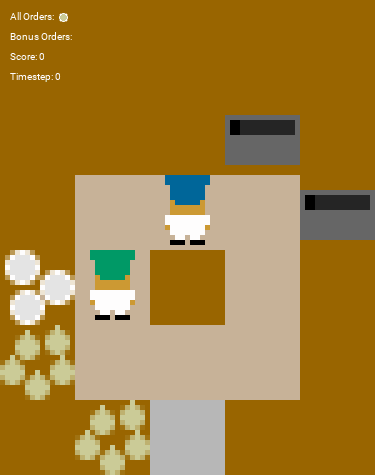

In [113]:
with open(gif_path, 'rb') as f:
    display(IPImage(data=f.read(), format='png'))